# File: exercise_2.py
Description: Analyze the Run I CMS H -> 4l data (see Table 4)
``` 
   N
   b_hat_zz
   b_hat_zx
   s_hat
```
which pertains to data in the range 121.5 <= mH <= 130.5 GeV for 7 and 8 TeV data.

 - Created: 18-Dec-2015 CMSDAS 2016, LPC Fermilab HBP
 - Updated: 24-Dec-2015 HBP - Add Bayesian calculation. Use MCMC to perform 9-D integral over nuisance parameters
 - Updated: 10-Jan-2019 JMD

In [1]:
import os,sys,re
from time import sleep
from string import split, strip, atof, find, replace, joinfields
import math
import ROOT as rt

Welcome to JupyROOT 6.12/07


In [2]:
# get list of variables from an expression
# being careful not to treat basic functions
# as variables
words = re.compile('[a-zA-Z][a-zA-Z0-9_]*[\[\]\.0-9]*')
hide  = re.compile('\bmin|max|log|exp|sqrt|pow\b')
def extractNames(expression):
    # hide basic functions
    expression = hide.sub("@", expression)
    vlist  = words.findall(expression)
    vl = []
    for x in vlist:
        if not (x in vl): vl.append(x)
    return vl

In [3]:
# replace each variable name in expression with an indexed name,
# but exclude the parameter of interest, which is not indexed.
def indexNames(expression, index, poi):
    names = extractNames(expression)
    for name in names:
        if name == poi: continue
        newword = re.compile(r'\b%s\b' % name)
        indexedname = '%s%d' % (name, index)
        expression  = newword.sub(indexedname, expression)
    return expression

In [4]:
def createParameters(wspace, filename):
        
    # read table, filter out comments and blank lines,
    # then split into fields
    records = map(split,
                  # filter out blank lines and lines that start with #
                  filter(lambda x: (x != '') and (x[0] != '#'),
                         # read table and strip away leading and trailing
                         # whitespace
                         map(strip, open(filename).readlines())))

    # create parameters, indexed by the bin number (start counting at 1)
    observations = []
    constants = []
    variables = []
    for t in records:
        name   = t[0]              # variable name
        values = map(atof, t[1:])  # values

        for ii, x in enumerate(values):
            # indexed name
            varname = '%s%d' % (name, ii+1)
            
            # create some reasonable bounds
            xmin = 0
            jj = int(x)
            xmax = 4*(jj+1)

            # create parameter
            cmd = '%s[%f, %f, %f]' % (varname, x, xmin, xmax)
            wspace.factory(cmd)

            if name[0] == 'N':
                observations.append(cmd)
            else:
                constants.append(cmd)
                wspace.var(varname).setConstant()
            
            # if this is a "hat" variable, create the
            # associated un-hatted parameter, which are
            # not to be made constant since they are the
            # unknowns.
            if find(varname, '_hat') > -1:
                varname = replace(varname, '_hat', '')
                cmd = '%s[%f, %f, %f]' % (varname, x, xmin, xmax)
                variables.append(cmd)
                wspace.factory(cmd)                        
    
    # parameter of interest
    cmd = 'mu[1, 0, 4]'
    variables.append(cmd)
    wspace.factory(cmd)
    wspace.var('mu').SetTitle('#mu')

    print "\nobservations =>\n\t%s" % joinfields(observations, '\n\t')
    print "\nconstants    =>\n\t%s" % joinfields(constants, '\n\t')
    print "\nvariables    =>\n\t%s" % joinfields(variables, '\n\t')

    nbins = len(records[0][1:])
    return nbins

In [5]:
def createWorkspace(wsname, wsfilename):
    # The most convenient way to use RooFit/RooStats is to 
    # make a workspace so that we can use its factory method
    wspace = rt.RooWorkspace(wsname)

    #-----------------------------------------------------
    # Create parameters
    #
    # Use the factory method of the RooWorkspace to create
    # parameters
    #
    # syntax:
    #        <name>[value, min-value, max-value]
    #-----------------------------------------------------
    # M = number of bins
    M = createParameters(wspace, 'Table4.dat')
    
    #-----------------------------------------------------
    # Create expressions, 1 set for each bin
    #
    # syntax:
    #        expr::<name>("expression", var1, var2, ...)
    #-----------------------------------------------------
    express = ['B_zz("(b_hat_zz/db_zz)^2", b_hat_zz, db_zz)',
               'tau_zz("b_hat_zz/db_zz^2", b_hat_zz, db_zz)',
               
               'B_zx("(b_hat_zx/db_zx)^2", b_hat_zx, db_zx)',
               'tau_zx("b_hat_zx/db_zx^2", b_hat_zx, db_zx)',
                              
               'S("(s_hat/ds)^2",   s_hat, ds)',
               'tau_s("s_hat/ds^2", s_hat, ds)',

               'tau_zzb_zz("tau_zz*b_zz", tau_zz, b_zz)',
               'tau_zxb_zx("tau_zx*b_zx", tau_zx, b_zx)',
               'tau_ss("tau_s*s", tau_s, s)',
               'n("mu*s + b_zz + b_zx", mu, s, b_zz, b_zx)']

    print '\nformulae =>'
    for t in express:
        rec = 'expr::%s' % t
        for ii in xrange(M):
            cmd = indexNames(rec, ii+1, 'mu')
            print "\t%s" % cmd
            wspace.factory(cmd)
        print
          
    print '\neffective counts and scale factors =>'
    for ii in xrange(M):
        for t in [('B_zz', 'tau_zz'),
                  ('B_zx', 'tau_zx'),
                  ('S',    'tau_s')]:
            name = '%s%d' % (t[0], ii+1)
            tau  = '%s%d' % (t[1], ii+1)
            print '\t%-8s = %8.2f\t%-8s = %8.2f' % \
                (name, wspace.function(name).getVal(),
                 tau,  wspace.function(tau).getVal())
        print

    #-----------------------------------------------------
    # Create pdfs
    #
    # syntax:
    #        pdf_name::<name>(var1, var2, ...)
    #
    # where the "Roo" prefix is dropped in pdf_name, e.g.
    #-----------------------------------------------------
    pdfs = [('Poisson', 'pN',    '(N, n)'),
            ('Poisson', 'pB_zz', '(B_zz, tau_zzb_zz, 1)'), 
            ('Poisson', 'pB_zx', '(B_zx, tau_zxb_zx, 1)'),
            ('Poisson', 'pS',    '(S,    tau_ss,     1)')]

    print '\npdfs =>'        
    prodpdf = ''
    pdfval1 = 1.0
    for t in pdfs:
        for ii in xrange(M):
            a = map(lambda x: indexNames(x, ii+1, 'mu'), t[1:])
            a = tuple([t[0]] + a)
            cmd = '%s::%s%s' % tuple(a)
            print '\t%s' % cmd
            wspace.factory(cmd)
            name = a[1]
            prodpdf += "%s, " % name
    prodpdf = prodpdf[:-2] # remove last ", "
    
    # multiply the pdfs together. use upper case PROD to
    # do this
    wspace.factory('PROD::model(%s)' % prodpdf)
    
    #-----------------------------------------------------
    # check RooFit calculation of product pdf
    #-----------------------------------------------------    
    print "\ncheck calculation of product pdf"
    for mu in [0.5, 1.0, 1.5]:
        wspace.var('mu').setVal(mu)
        pdfval1 = 1.0
        for t in pdfs:
            for ii in xrange(M):
                a = map(lambda x: indexNames(x, ii+1, 'mu'), t[1:])
                names = extractNames(a[-1])
                try:
                    N = wspace.var(names[0]).getVal()
                except:
                    N = wspace.function(names[0]).getVal()
                n = wspace.function(names[1]).getVal()
                pdfval1 *= rt.TMath.Poisson(N, n)
                
        pdfval2 = wspace.pdf('model').getVal()
        print 'mu = %5.2f\tmodel(explicit) = %10.4e\tmodel(RooFit) = %10.4e'%\
          (mu, pdfval1, pdfval2)

    #-----------------------------------------------------             
    # create a prior, since one is needed in Bayesian
    # calculations
    #-----------------------------------------------------
    wspace.factory('Uniform::prior_poi({mu})')
    wspace.factory('Uniform::prior_nuis({s1,s2,s3,'\
                   'b_zz1,b_zz2,b_zz3, '\
                   'b_zx1,b_zx2,b_zx3})')
    wspace.factory('PROD::prior(prior_poi,prior_nuis)')

    #-----------------------------------------------------
    # Define a few useful sets.
    #-----------------------------------------------------
    sets = [('obs',  'N1,N2,N3'),    # observations
            # parameter of interest
            ('poi',  'mu'),          
            # nuisance parameters
            ('nuis', 's1,s2,s3,b_zz1,b_zz2,b_zz3,b_zx1,b_zx2,b_zx3')] 
    for t in sets:
        name, parlist = t
        wspace.defineSet(name, parlist)
    
    #-----------------------------------------------------        
    # create a dataset
    #-----------------------------------------------------    
    data = rt.RooDataSet('data', 'data', wspace.set('obs'))
    data.add(wspace.set('obs'))
    # import dataset into workspace.
    # The last argument is a workaround a PyROOT "feature".
    # The last argument ensures that the correct version of
    # the import method is called.
    getattr(wspace, 'import')(data, rt.RooCmdArg())
        
    #-----------------------------------------------------
    # Create model configuration. This is needed for the
    # statistical analyses
    #-----------------------------------------------------
    cfg = rt.RooStats.ModelConfig('cfg')
    cfg.SetWorkspace(wspace)
    cfg.SetPdf(wspace.pdf('model'))
    cfg.SetPriorPdf(wspace.pdf('prior'))
    cfg.SetParametersOfInterest(wspace.set('poi'))
    cfg.SetNuisanceParameters(wspace.set('nuis'))

    # import model configuration into workspace
    getattr(wspace, 'import')(cfg)
    
    # write out workspace
    wspace.writeToFile(wsfilename)

In [19]:
def analyzeWorkspace(wsname, wsfilename):

    # Open workspace file
    wsfile = rt.TFile.Open(wsfilename)

    # Get workspace
    wspace = wsfile.Get(wsname)
    wspace.Print()
    
    # Get data
    data = wspace.data('data')

    # Get model configuration    
    cfg  = wspace.obj('cfg')

    #-----------------------------------------------------    
    # Fit model to data
    #-----------------------------------------------------
    results = wspace.pdf('model').fitTo(data, rt.RooFit.Save())
    results.Print()
    # get maximum likelihood estimate (MLE) of mu
    bestFit = wspace.var('mu').getVal()

    
    #-----------------------------------------------------    
    # Compute interval based on profile likelihood
    #-----------------------------------------------------
    # suppress some (apparently) innocuous warnings
    #msgservice = rt.RooMsgService.instance()
    #msgservice.setGlobalKillBelow(rt.RooFit.FATAL)
        
    print '== Profile likelihood calculations =='
    plc = rt.RooStats.ProfileLikelihoodCalculator(data, cfg)
    CL  = 0.683
    plc.SetConfidenceLevel(CL)
    plcInterval = plc.GetInterval()
    # plot interval
    plcplot = rt.RooStats.LikelihoodIntervalPlot(plcInterval)
    plccanvas = rt.TCanvas('fig_PL', 'plc', 10, 10, 400, 400)
    plcplot.Draw()
    plccanvas.Update()
    plccanvas.Draw()
    plccanvas.SaveAs('.png')

    # get central interval
    lowerLimit1  = plcInterval.LowerLimit(wspace.var('mu'))
    upperLimit1  = plcInterval.UpperLimit(wspace.var('mu'))
    print '\t%4.1f%s CL interval = [%5.3f, %5.3f]' % \
      (100*CL, '%', lowerLimit1, upperLimit1)
          
    # compute a 95% upper limit on mu by
    # computing a 90% central interval and
    # ignoring the lower limit
    CL = 0.90
    plc.SetConfidenceLevel(CL)
    plcInterval = plc.GetInterval()
    upperLimit  = plcInterval.UpperLimit(wspace.var('mu'))
    CL = 0.95
    print '\t%4.1f%s upper limit = %5.3f' % \
      (100*CL, '%', upperLimit)      

    # compute upper and lower interval bounds relative to
    # best fit value of mu
    upper   = upperLimit1-bestFit
    lower   = bestFit-lowerLimit1
    print '\tmu (MLE)          = %5.3f -%-5.3f/+%-5.3f' % \
      (bestFit, lower, upper)

    # compute a standard measure of significance:
    #   q(mu) = -2*log [Lp(mu) / Lp(mu_hat)]
    # where Lp(mu) is the profile likelihood and mu_hat
    # is the MLE of mu (the best fit value).
    # basically, we are testing the hypothesis that
    # mu = 0. We define the significance measure so
    # that large values cast doubt on the mu=0
    # hypothesis.
    # 1. get the negative log-profilelikelihood ratio
    logplratio = plcInterval.GetLikelihoodRatio()
    # 2. set value of mu to zero (no-signal)
    wspace.var('mu').setVal(0)
    # 3. compute q(0) 
    q0 = 2*logplratio.getVal()
    # 4. compute a measure that is approximately Z
    # standard deviations from mu = 0
    Z  = math.sqrt(q0)
    print "\tZ = sqrt(q(0))    = %5.3f" % Z
    print "\twhere q(mu) = -2*log[Lp(mu)/Lp(mu_hat)]\n"    
    
    #-----------------------------------------------------    
    # Compute Bayesian interval. Use MCMC to marginalize
    # over nuisance parameters.
    #-----------------------------------------------------
    print '\n== Bayesian calculations =='
    print '== using MCMC to perform 9D marginalization integrals'

    # create a reasonable proposal function, that is, a
    # probability density for randomly proposing a new
    # point. 
    ph = rt.RooStats.ProposalHelper()
    ph.SetVariables(results.floatParsFinal())
    ph.SetCovMatrix(results.covarianceMatrix())
    ph.SetUpdateProposalParameters(True)
    ph.SetCacheSize(100)
    pf = ph.GetProposalFunction()

    # perform integration via MCMC
    mc = rt.RooStats.MCMCCalculator(data, cfg)
    mc.SetProposalFunction(pf)
    mc.SetNumBurnInSteps(500)       # number of points to skip
    mc.SetNumIters(50000)           # number of interations
    CL68  = 0.683
    mc.SetConfidenceLevel(CL)    
    mc.SetLeftSideTailFraction(0.5) # compute central interval
    mcInterval = mc.GetInterval()
    lowerLimit1 = mcInterval.LowerLimit(wspace.var('mu'))
    upperLimit1 = mcInterval.UpperLimit(wspace.var('mu'))

    CL  = 0.95
    mc.SetConfidenceLevel(CL)
    mc.SetLeftSideTailFraction(0)   # compute upper limit
    mcInterval2 = mc.GetInterval()
    upperLimit = mcInterval2.UpperLimit(wspace.var('mu'))

    print
    print '\t%4.1f%s CL interval = [%5.3f, %5.3f]' % \
      (100*CL68, '%', lowerLimit1, upperLimit1)    
    print '\t%4.1f%s upper limit = %5.3f\n' % \
      (100*CL, '%', upperLimit) 
    
    return plccanvas

In [7]:
createWorkspace('CMSDAS16',  'three_count.root')


observations =>
	N1[4.000000, 0.000000, 20.000000]
	N2[13.000000, 0.000000, 56.000000]
	N3[8.000000, 0.000000, 36.000000]

constants    =>
	b_hat_zz1[1.100000, 0.000000, 8.000000]
	b_hat_zz2[3.200000, 0.000000, 16.000000]
	b_hat_zz3[2.500000, 0.000000, 12.000000]
	db_zz1[0.100000, 0.000000, 4.000000]
	db_zz2[0.200000, 0.000000, 4.000000]
	db_zz3[0.200000, 0.000000, 4.000000]
	b_hat_zx1[0.800000, 0.000000, 4.000000]
	b_hat_zx2[1.300000, 0.000000, 8.000000]
	b_hat_zx3[0.400000, 0.000000, 4.000000]
	db_zx1[0.200000, 0.000000, 4.000000]
	db_zx2[0.300000, 0.000000, 4.000000]
	db_zx3[0.200000, 0.000000, 4.000000]
	s_hat1[3.000000, 0.000000, 16.000000]
	s_hat2[7.900000, 0.000000, 32.000000]
	s_hat3[6.400000, 0.000000, 28.000000]
	ds1[0.400000, 0.000000, 4.000000]
	ds2[1.000000, 0.000000, 8.000000]
	ds3[0.700000, 0.000000, 4.000000]

variables    =>
	b_zz1[1.100000, 0.000000, 8.000000]
	b_zz2[3.200000, 0.000000, 16.000000]
	b_zz3[2.500000, 0.000000, 12.000000]
	b_zx1[0.800000, 0.000000, 4.000

== Profile likelihood calculations ==
	68.3% CL interval = [0.628, 1.224]
	95.0% upper limit = 1.458
	mu (MLE)          = 0.904 -0.275/+0.321
	Z = sqrt(q(0))    = 4.164
	where q(mu) = -2*log[Lp(mu)/Lp(mu_hat)]


== Bayesian calculations ==
== using MCMC to perform 9D marginalization integrals

	68.3% CL interval = [0.314, 3.950]
	95.0% upper limit = 3.151


RooWorkspace(CMSDAS16) CMSDAS16 contents

variables
---------
(N1,N2,N3,b_hat_zx1,b_hat_zx2,b_hat_zx3,b_hat_zz1,b_hat_zz2,b_hat_zz3,b_zx1,b_zx2,b_zx3,b_zz1,b_zz2,b_zz3,db_zx1,db_zx2,db_zx3,db_zz1,db_zz2,db_zz3,ds1,ds2,ds3,mu,s1,s2,s3,s_hat1,s_hat2,s_hat3)

p.d.f.s
-------
RooProdPdf::model[ pN1 * pN2 * pN3 * pB_zz1 * pB_zz2 * pB_zz3 * pB_zx1 * pB_zx2 * pB_zx3 * pS1 * pS2 * pS3 ] = 2.90655e-15
RooPoisson::pB_zx1[ x=B_zx1 mean=tau_zxb_zx1 ] = 0.0992175
RooPoisson::pB_zx2[ x=B_zx2 mean=tau_zxb_zx2 ] = 0.091656
RooPoisson::pB_zx3[ x=B_zx3 mean=tau_zxb_zx3 ] = 0.195367
RooPoisson::pB_zz1[ x=B_zz1 mean=tau_zzb_zz1 ] = 0.0362425
RooPoisson

Warning in <TCanvas::Constructor>: Deleting canvas with same name: fig_PL
Info in <TCanvas::Print>: png file ./fig_PL.png has been created


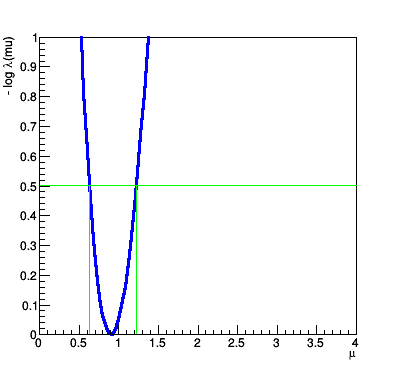

In [20]:
plccanvas = analyzeWorkspace('CMSDAS16', 'three_count.root')